# Training Notebook for the RBF Approach

### Import Dependencies

In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import os
from utils import *
import joblib

model_output_path = 'models'
os.makedirs(model_output_path, exist_ok=True)

In [2]:
#set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
pl.seed_everything(42)
torch.backends.cudnn.deterministic = True

Seed set to 42


### Dataset & Dataloader Definition

In [3]:
df_filtered = pd.read_csv("rbf_features.csv")
df_train = pd.read_csv("splits/train.csv")
df_val = pd.read_csv("splits/val.csv")
df_test = pd.read_csv("splits/test.csv")

# Preprocessing
feature_columns = [col for col in df_train.columns if col not in ["label", "exp_name"]]
scaler = StandardScaler()
scaler.fit(df_train[feature_columns])
mean = scaler.mean_
std = scaler.scale_

# Label encoding
exp_labels = df_filtered.groupby("exp_name")["label"].first()
label_encoder = LabelEncoder()
label_encoder.fit(exp_labels.values)
exp_name_to_label = exp_labels.to_dict()
print("# labels = ", len(label_encoder.classes_))

train_dataset = SensorDataset(df_train, exp_name_to_label, label_encoder, mean, std)
val_dataset   = SensorDataset(df_val,   exp_name_to_label, label_encoder, mean, std)
test_dataset  = SensorDataset(df_test,  exp_name_to_label, label_encoder, mean, std)

# labels =  17


In [4]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 339
Validation dataset size: 41
Test dataset size: 41


In [5]:
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Model Training

#### MLP

hidden dimension = 64

In [6]:
hidden_dim = [64]
model = MLPClassifier(
    num_features=len(feature_columns),
    hidden_dims=hidden_dim,
    num_classes=len(label_encoder.classes_),
    lr=1e-4,
    dropout=0.2,
    weight_decay=1e-5
)

In [ ]:
MAX_EPOCHS = 1000
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=MAX_EPOCHS // 10,
    verbose=False,
    mode="min"
)

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    log_every_n_steps=20,
    callbacks=[early_stop_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1
)

trainer.fit(model, train_loader, val_loader)
# Save the model
output_name = f"MLP_h{hidden_dim}_{now_date()}.ckpt"
trainer.save_checkpoint(os.path.join(model_output_path, output_name))

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 6.3 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
6.3 K     Trainable params
0       

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 597: 100%|██████████| 21/21 [00:00<00:00, 21.73it/s, v_num=0, train_acc=0.312, val_acc=0.341] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  8.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.26829269528388977
        test_loss            2.457026481628418
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


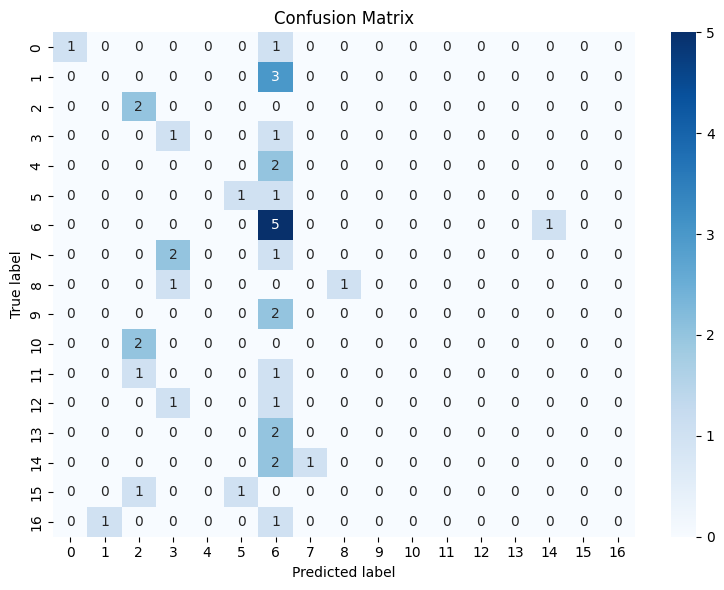

In [13]:
model = MLPClassifier.load_from_checkpoint(os.path.join(model_output_path, output_name))
model.eval()
trainer.test(model, test_loader)
plot_confusion_matrix(model, test_loader)

hidden dim = 256

In [14]:
hidden_dim = [256]
model = MLPClassifier(
    num_features=len(feature_columns),
    hidden_dims=hidden_dim,
    num_classes=len(label_encoder.classes_),
    lr=1e-4,
    dropout=0.2,
    weight_decay=1e-5
)

In [15]:
MAX_EPOCHS = 1000
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=MAX_EPOCHS // 10,
    verbose=False,
    mode="min"
)

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    log_every_n_steps=20,
    callbacks=[early_stop_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1
)

trainer.fit(model, train_loader, val_loader)
# Save the model
output_name = f"MLP_h{hidden_dim}_{now_date()}.ckpt"
trainer.save_checkpoint(os.path.join(model_output_path, output_name))

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 25.1 K | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
25.1 K    Trainable params
0         Non-trainable params
25.1 K    Total params
0.100     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 715: 100%|██████████| 21/21 [00:01<00:00, 19.02it/s, v_num=2, train_acc=0.688, val_acc=0.463] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 16.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.39024388790130615
        test_loss            2.48000431060791
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


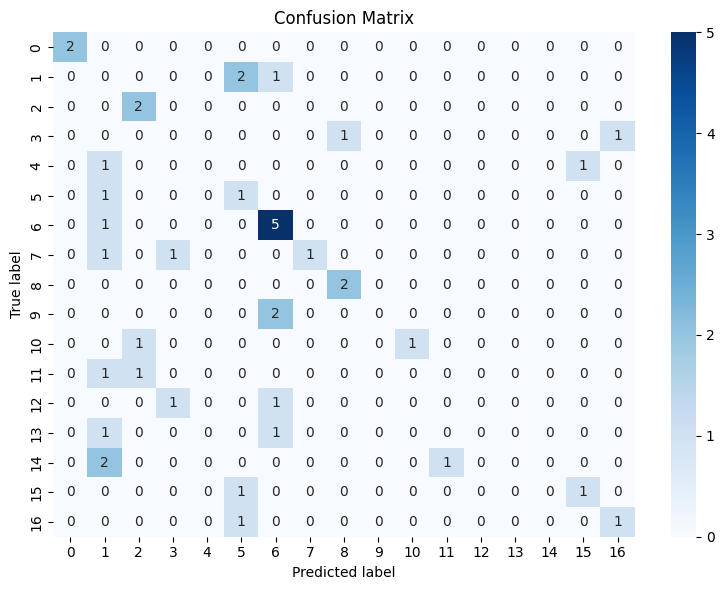

In [16]:
model = MLPClassifier.load_from_checkpoint(os.path.join(model_output_path, output_name))
model.eval()
trainer.test(model, test_loader)
plot_confusion_matrix(model, test_loader)

2 hidden dims: 64 -> 64

In [17]:
hidden_dim = [64, 64]
model = MLPClassifier(
    num_features=len(feature_columns),
    hidden_dims=hidden_dim,
    num_classes=len(label_encoder.classes_),
    lr=1e-4,
    dropout=0.2,
    weight_decay=1e-5
)

In [18]:
MAX_EPOCHS = 1000
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=MAX_EPOCHS // 10,
    verbose=False,
    mode="min"
)

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    log_every_n_steps=20,
    callbacks=[early_stop_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1
)

trainer.fit(model, train_loader, val_loader)
# Save the model
output_name = f"MLP_h{hidden_dim}_{now_date()}.ckpt"
trainer.save_checkpoint(os.path.join(model_output_path, output_name))

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 10.4 K | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
10.4 K    Trainable params
0         Non-trainable params
10.4 K    Total params
0.042     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 999: 100%|██████████| 21/21 [00:00<00:00, 22.79it/s, v_num=3, train_acc=0.562, val_acc=0.439] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 21/21 [00:00<00:00, 22.20it/s, v_num=3, train_acc=0.562, val_acc=0.439]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 13.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4146341383457184
        test_loss            2.153029680252075
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


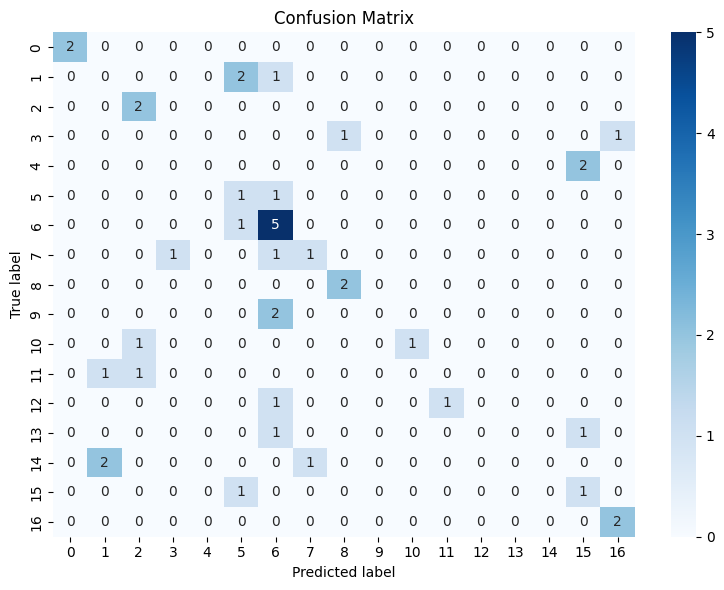

In [19]:
model = MLPClassifier.load_from_checkpoint(os.path.join(model_output_path, output_name))
model.eval()
trainer.test(model, test_loader)
plot_confusion_matrix(model, test_loader)

#### Random Forest & KNN

In [20]:
def dataset_to_numpy(dataset):
    features = []
    labels = []
    for i in range(len(dataset)):
        x, y, _ = dataset[i]
        features.append(x.numpy())
        labels.append(y)
    return np.stack(features), np.array(labels)

# Convert datasets to numpy
X_train, y_train = dataset_to_numpy(train_dataset)
X_val, y_val = dataset_to_numpy(val_dataset)
X_test, y_test = dataset_to_numpy(test_dataset)

In [21]:
# Option 1: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate Random Forest
print("Random Forest Results:")
y_pred_rf = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

# Save the model
rf_output_name = f"RandomForest_{now_date()}.joblib"
joblib.dump(rf_model, os.path.join(model_output_path, rf_output_name))

Random Forest Results:
Accuracy: 0.43902439024390244
                    precision    recall  f1-score   support

       ACETIC_ACID       1.00      1.00      1.00         2
           ACETONE       0.43      1.00      0.60         3
               AIR       0.67      1.00      0.80         2
           AMMONIA       0.17      0.50      0.25         2
 AMMONIUM_CHLORIDE       0.00      0.00      0.00         2
   CALCIUM_NITRATE       0.33      0.50      0.40         2
            DIESEL       0.43      0.50      0.46         6
           ETHANOL       0.00      0.00      0.00         3
       FORMIC_ACID       1.00      0.50      0.67         2
          GASOLINE       0.50      0.50      0.50         2
HYDROGENE_PEROXIDE       0.00      0.00      0.00         2
       ISOPROPANOL       0.00      0.00      0.00         2
          KEROSENE       0.50      0.50      0.50         2
            NAPHTA       0.00      0.00      0.00         2
      NITROMETHANE       0.50      0.33      0

c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

['models\\RandomForest_17052025_1511.joblib']

In [22]:
# Option 2: K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Evaluate KNN
print("\nK-Nearest Neighbors Results:")
y_pred_knn = knn_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_))

# Save the model
knn_output_name = f"KNN_{now_date()}.joblib"
joblib.dump(knn_model, os.path.join(model_output_path, knn_output_name))


K-Nearest Neighbors Results:
Accuracy: 0.2682926829268293
                    precision    recall  f1-score   support

       ACETIC_ACID       0.33      0.50      0.40         2
           ACETONE       0.17      0.33      0.22         3
               AIR       0.67      1.00      0.80         2
           AMMONIA       0.17      0.50      0.25         2
 AMMONIUM_CHLORIDE       0.00      0.00      0.00         2
   CALCIUM_NITRATE       0.33      0.50      0.40         2
            DIESEL       0.33      0.33      0.33         6
           ETHANOL       0.00      0.00      0.00         3
       FORMIC_ACID       1.00      0.50      0.67         2
          GASOLINE       0.00      0.00      0.00         2
HYDROGENE_PEROXIDE       0.00      0.00      0.00         2
       ISOPROPANOL       0.00      0.00      0.00         2
          KEROSENE       0.00      0.00      0.00         2
            NAPHTA       0.33      0.50      0.40         2
      NITROMETHANE       0.25      0.33 

c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\miche\OneDrive\Desktop\tesi\

['models\\KNN_17052025_1511.joblib']